##Installation of Dependencies

In [ ]:
%matplotlib inline
!pip install --quiet transformers
!pip install -q pytorch_transformers
!pip install -q tensorflow-text

##Importing **Data Set**

In [ ]:
TRAIN_DATASET_PATH = "/content/train.csv" # directory path where the training dataset is located
TEST_DATASET_PATH = "/content/test.csv" # directory path where the test dataset is located

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = test_df.dropna()
train_df = train_df.dropna()

#This hyperparameter can be set and has a preferred range between 0.1 and 0.2
validation_split = 0.1
train_df,val_df = train_test_split(train_df, test_size = validation_split, random_state = 100)
#When splitting data, an index column will be added. It is dropped using this command
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

##Importing the model

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Model checkpoint token: it is used to specify which model to download from pre trained hugging face models
model_tk="xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_tk)
model = AutoModel.from_pretrained(model_tk)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Tokenization of the Data

In [ ]:
import numpy as np
import torch

# Set of functions used to build and tokenized the data with padding and converting it into torch tensors
def tokenize_text(df, max_seq):
    return [tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.news.values]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [ ]:
max_seq = 60 # Hyperparameter
train_indices = tokenize_and_pad_text(train_df, max_seq)
val_indices = tokenize_and_pad_text(val_df, max_seq)
test_indices = tokenize_and_pad_text(test_df, max_seq)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
x = model.to(device)

##Vectorization of the Data

In [ ]:
with torch.no_grad():
    x_train = x(train_indices.to(device))[0]
    torch.cuda.empty_cache()  # Model' s outputs are tuples
    x_val = x(val_indices.to(device))[0]
    torch.cuda.empty_cache()
    x_test = x(test_indices.to(device))[0]
    torch.cuda.empty_cache()


In [ ]:
target_columns = ["label"]
y_train = targets_to_tensor(train_df, target_columns)
y_val = targets_to_tensor(val_df, target_columns)
y_test = targets_to_tensor(test_df, target_columns)

##Model declaration

In [ ]:
from tensorflow import random
random.set_seed(1) # To Create a stable model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes

        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [ ]:
x_train.shape

torch.Size([2069, 60, 1024])

In [ ]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 10 # Kernel number tells you the number of kernels that are present per Convolution Network
kernel_sizes = [3,5,7,9] # Kernel or filter's Dimensions
dropout = 0 # Dropout fraction
static = True

In [ ]:
# Declaration of model parameters
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)
model=model.to(device)

In [ ]:
# Model Parameters
n_epochs = 100
batch_size = 16
lr = 0.00005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [ ]:
# Generates the Batches
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

##Running The Model

In [ ]:
import time
from torch.autograd import Variable

# Training the model with the train dataset
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch.to(device))
        optimizer.zero_grad()
        loss = loss_fn(y_pred.to(device), y_batch.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    # Calculation of loss for the Validation Data
    model.eval()
    # deactivate autograd engine to reduce memory usage and speed up computations
    with torch.no_grad():
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred.to(device), y_batch.to(device))
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.64. Validation loss: 0.64. Elapsed time: 1.57s.
Epoch 2 Train loss: 0.62. Validation loss: 0.63. Elapsed time: 0.35s.
Epoch 3 Train loss: 0.60. Validation loss: 0.61. Elapsed time: 0.36s.
Epoch 4 Train loss: 0.57. Validation loss: 0.59. Elapsed time: 0.36s.
Epoch 5 Train loss: 0.55. Validation loss: 0.57. Elapsed time: 0.35s.
Epoch 6 Train loss: 0.53. Validation loss: 0.56. Elapsed time: 0.34s.
Epoch 7 Train loss: 0.51. Validation loss: 0.54. Elapsed time: 0.33s.
Epoch 8 Train loss: 0.49. Validation loss: 0.52. Elapsed time: 0.33s.
Epoch 9 Train loss: 0.47. Validation loss: 0.50. Elapsed time: 0.34s.
Epoch 10 Train loss: 0.46. Validation loss: 0.49. Elapsed time: 0.34s.
Epoch 11 Train loss: 0.44. Validation loss: 0.48. Elapsed time: 0.33s.
Epoch 12 Train loss: 0.43. Validation loss: 0.46. Elapsed time: 0.34s.
Epoch 13 Train loss: 0.41. Validation loss: 0.45. Elapsed time: 0.34s.
Epoch 14 Train loss: 0.40. Validation loss: 0.44. Elapsed time: 0.33s.
Epoch 15 Train 

##Plotting The loss graph

Text(0.5, 1.0, 'Losses')

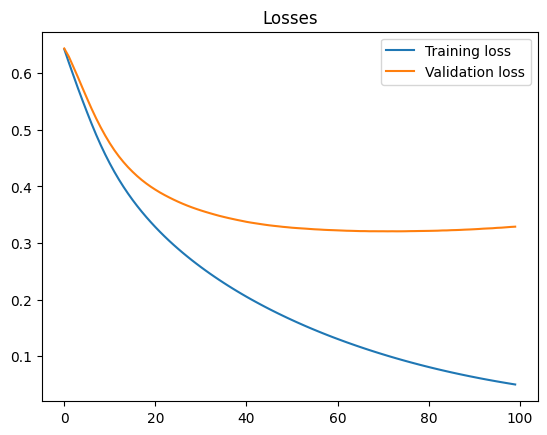

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Printing Loss graph
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

##Model Prediction

In [ ]:
random.set_seed(1)

In [ ]:
model.eval()
# Deactivate autograd engine to reduce memory usage and speed up computations
with torch.no_grad():
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [ ]:
# Preparing and Generating the Test labels
y_test_np = test_df[target_columns].values
y_test = list(map(lambda x: int(x) , y_test_np))
# Preparing the predicted variables
y_pred = y_preds_np.round()
y_pred = list(map(lambda x: int(x) , y_pred))

In [ ]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80       200
           1       0.83      0.95      0.89       300

    accuracy                           0.85       500
   macro avg       0.87      0.83      0.84       500
weighted avg       0.86      0.85      0.85       500



<Axes: >

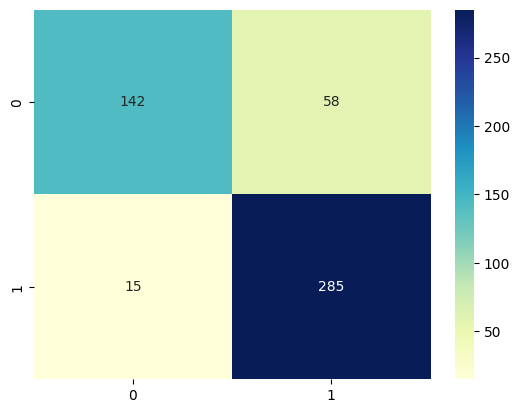

In [ ]:
# confusion matrix
from sklearn.metrics import  confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data = cm)
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')